In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import e3nn_jax as e3nn
import plotly.graph_objects as go
import pandas as pd
import optax
import chex
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import functools
sys.path.append('../..')

/Users/ameyad/Documents/spherical-harmonic-net/.venv/lib/python3.10/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/ameyad/Documents/spherical-harmonic-net/.venv/lib/python3.10/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

from symphony import loss
from symphony import models
import helpers

/Users/ameyad/Documents/spherical-harmonic-net/.venv/lib/python3.10/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [4]:
res_alphas = [9, 179, 359, 719]
res_betas = [10, 180, 360]

In [5]:
# Create a random signal on the sphere, by sampling random points on the sphere.
N_points = 5
lmax = 5
rng = jax.random.PRNGKey(0)
random_points = jax.random.normal(rng, (N_points, 3))
random_points = random_points / jnp.linalg.norm(random_points, axis=-1, keepdims=True)
random_signal = 20 * e3nn.s2_dirac(random_points, lmax=lmax, p_val=1, p_arg=-1)

In [6]:
random_dist = helpers.average_target_distributions(random_signal, 159, 80)
best_mean_dist, best_std_dist = helpers.rmse_of_samples(random_dist, random_points, rng)
print(best_mean_dist, best_std_dist)

0.056903224 0.03038828


In [7]:
random_dist_copy = e3nn.SphericalSignal(grid_values=random_dist.grid_values[0], quadrature=random_dist.quadrature)
fig = go.Figure([go.Surface(random_dist_copy.plotly_surface(scale_radius_by_amplitude=False, radius=0.8, normalize_radius_by_max_amplitude=True)),
                 go.Scatter3d(x=random_points[:, 0], y=random_points[:, 1], z=random_points[:, 2], mode='markers')])

# Do not show the axis
fig.update_layout(scene = dict(
                    xaxis = dict(showticklabels=False, visible=False),
                    yaxis = dict(showticklabels=False, visible=False),
                    zaxis = dict(showticklabels=False, visible=False)))
fig.show()

In [8]:
# Try to learn random signal via gradient descent on the KL divergence.
def optimize_coeffs(true_signal, lmax, position_channels, res_alpha, res_beta, num_training_steps):

    # Compute the target distribution
    true_dist = helpers.average_target_distributions(true_signal, res_alpha, res_beta)

    rng = jax.random.PRNGKey(0)
    irreps = e3nn.s2_irreps(lmax, p_val=1, p_arg=-1)
    coeffs = e3nn.normal(irreps, rng, (position_channels, 1))

    tx = optax.adam(1e-3)
    opt_state = tx.init(coeffs)

    def loss_fn(coeffs):
        log_predicted_dist = models.log_coeffs_to_logits(coeffs, res_beta=res_beta, res_alpha=res_alpha, num_radii=1)
        return loss.kl_divergence_on_spheres(true_dist, log_predicted_dist)

    @jax.jit
    def train_step(coeffs, opt_state):
        loss_value, grads = jax.value_and_grad(loss_fn)(coeffs)
        grad_norms = jnp.linalg.norm(grads.array)
        updates, opt_state = tx.update(grads, opt_state, coeffs)
        coeffs = optax.apply_updates(coeffs, updates)
        return coeffs, opt_state, loss_value, grad_norms


    training_dict = {}
    for step in range(num_training_steps):
        coeffs, opt_state, loss_value, grad_norms = train_step(coeffs, opt_state)
        if step % 5000 == 0:
            print(f"Step {step}, Loss: {loss_value}")
        
        if step % 10 == 0:
            step_rng = jax.random.fold_in(rng, step)
            dist = helpers.coeffs_to_distribution(coeffs, res_alpha, res_beta)
            mean_dist, std_dist = helpers.rmse_of_samples(dist, random_points, step_rng, num_samples=1000)
            
            training_dict[step] = {
                "coeffs": coeffs.array,
                "loss_value": float(loss_value),
                "grad_norms": float(grad_norms),
                "mean_dist": float(mean_dist),
                "std_dist": float(std_dist),
            }

    return training_dict


In [9]:
# We vary the number of position channels and lmax.
# See how well we can learn the signal.
results_df = pd.DataFrame(columns=["res_alpha", "res_beta", "lmax", "position_channels", "loss", "coeffs", "grad_norms", "mean_dist", "std_dist"])
for res_alpha in res_alphas:
    for res_beta in res_betas:
        for lmax in [5]:
            for position_channels in [2]:
                training_dict = optimize_coeffs(random_signal, lmax, position_channels, res_alpha, res_beta, num_training_steps=10000) 
                
                first_step = list(training_dict.keys())[0]
                last_step = list(training_dict.keys())[-1]
                assert first_step == 0

                results_df = results_df.append({
                    "res_alpha": res_alpha,
                    "res_beta": res_beta,
                    "lmax": lmax,
                    "position_channels": position_channels,
                    "steps": [step for step in training_dict.keys()],
                    "loss": [training_dict[step]["loss_value"] for step in training_dict.keys()],
                    "grad_norms": [training_dict[step]["grad_norms"] for step in training_dict.keys()],
                    "coeffs": training_dict[last_step]["coeffs"],
                    "mean_dist": [training_dict[step]["mean_dist"] for step in training_dict.keys()],
                    "std_dist": [training_dict[step]["std_dist"] for step in training_dict.keys()],
                }, ignore_index=True)
        

Step 0, Loss: 6.017305850982666
Step 5000, Loss: 0.015345342457294464


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_79608/1038274888.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Step 0, Loss: 6.983218669891357
Step 5000, Loss: 0.126348614692688


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_79608/1038274888.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Step 0, Loss: 6.983217239379883
Step 5000, Loss: 0.12634867429733276


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_79608/1038274888.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Step 0, Loss: 7.611118316650391
Step 5000, Loss: 0.16499507427215576


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_79608/1038274888.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Step 0, Loss: 8.355302810668945
Step 5000, Loss: 0.26645076274871826


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_79608/1038274888.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Step 0, Loss: 8.355304718017578
Step 5000, Loss: 0.2664511203765869


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_79608/1038274888.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Step 0, Loss: 7.611118793487549
Step 5000, Loss: 0.1649952530860901


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_79608/1038274888.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Step 0, Loss: 8.355304718017578
Step 5000, Loss: 0.26645028591156006


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_79608/1038274888.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Step 0, Loss: 8.355302810668945
Step 5000, Loss: 0.2664501667022705


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_79608/1038274888.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Step 0, Loss: 7.611119270324707
Step 5000, Loss: 0.16499531269073486


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_79608/1038274888.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Step 0, Loss: 8.355306625366211
Step 5000, Loss: 0.26645052433013916


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_79608/1038274888.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Step 0, Loss: 8.355302810668945
Step 5000, Loss: 0.26644957065582275


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_79608/1038274888.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [10]:
results_df

,res_alpha,res_beta,lmax,position_channels,loss,coeffs,grad_norms,mean_dist,std_dist,steps
0,9,10,5,2,"[6.017305850982666, 5.769235134124756, 5.53030...","[[[-0.32481343, 0.718475, -3.9259121, -0.50022...","[4.043649196624756, 3.8830134868621826, 3.7186...","[0.6139663457870483, 0.6139492392539978, 0.594...","[0.19349855184555054, 0.21801814436912537, 0.2...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1..."
1,9,180,5,2,"[6.983218669891357, 6.724329471588135, 6.47559...","[[[-0.88071275, 3.3468542, -3.789999, -0.43628...","[4.250628471374512, 4.066045761108398, 3.87576...","[0.6193149089813232, 0.6079345941543579, 0.602...","[0.19917990267276764, 0.22252246737480164, 0.2...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1..."
2,9,360,5,2,"[6.983217239379883, 6.724329471588135, 6.47559...","[[[-0.8807383, 3.3468335, -3.7899592, -0.43626...","[4.2506279945373535, 4.066044807434082, 3.8757...","[0.6201196312904358, 0.6061385869979858, 0.604...","[0.2000894844532013, 0.2234339863061905, 0.226...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1..."
3,179,10,5,2,"[7.611118316650391, 7.391840934753418, 7.17863...","[[[-2.5666695, 0.07566207, -2.7200928, -3.2806...","[3.268716812133789, 3.2015185356140137, 3.1234...","[0.31879541277885437, 0.31417831778526306, 0.3...","[0.21827541291713715, 0.22159388661384583, 0.2...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1..."
4,179,180,5,2,"[8.355302810668945, 8.131488800048828, 7.91356...","[[[-4.009645, 0.60842615, -2.9040878, -2.20228...","[3.3280229568481445, 3.256693124771118, 3.1801...","[0.3487367331981659, 0.34023335576057434, 0.34...","[0.21400417387485504, 0.21710547804832458, 0.2...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1..."
5,179,360,5,2,"[8.355304718017578, 8.131492614746094, 7.91356...","[[[-4.009692, 0.60842496, -2.9040523, -2.20226...","[3.328021287918091, 3.25669264793396, 3.180181...","[0.34897470474243164, 0.34016358852386475, 0.3...","[0.214095801115036, 0.21725209057331085, 0.230...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1..."
6,359,10,5,2,"[7.611118793487549, 7.391842365264893, 7.17863...","[[[-2.5666254, 0.07566545, -2.7201178, -3.2807...","[3.268716812133789, 3.2015185356140137, 3.1234...","[0.318850040435791, 0.3136022090911865, 0.3302...","[0.21834219992160797, 0.22187373042106628, 0.2...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1..."
7,359,180,5,2,"[8.355304718017578, 8.131490707397461, 7.91357...","[[[-4.009971, 0.6084016, -2.903551, -2.2021282...","[3.328019142150879, 3.256692409515381, 3.18018...","[0.34885576367378235, 0.3403471112251282, 0.34...","[0.2140013426542282, 0.21767909824848175, 0.23...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1..."
8,359,360,5,2,"[8.355302810668945, 8.131490707397461, 7.91356...","[[[-4.0101256, 0.6083966, -2.903341, -2.202055...","[3.3280210494995117, 3.256692886352539, 3.1801...","[0.3490886390209198, 0.3405502438545227, 0.340...","[0.21394699811935425, 0.21748049557209015, 0.2...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1..."
9,719,10,5,2,"[7.611119270324707, 7.391842365264893, 7.17863...","[[[-2.5666282, 0.075663805, -2.7201176, -3.280...","[3.268717050552368, 3.201519012451172, 3.12346...","[0.31903067231178284, 0.31385061144828796, 0.3...","[0.21844206750392914, 0.22172337770462036, 0.2...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1..."


In [45]:
def get_color_value(res_alpha, res_beta):
    return np.cbrt((res_alpha * res_beta) / (np.max(res_alphas) * np.max(res_betas)))

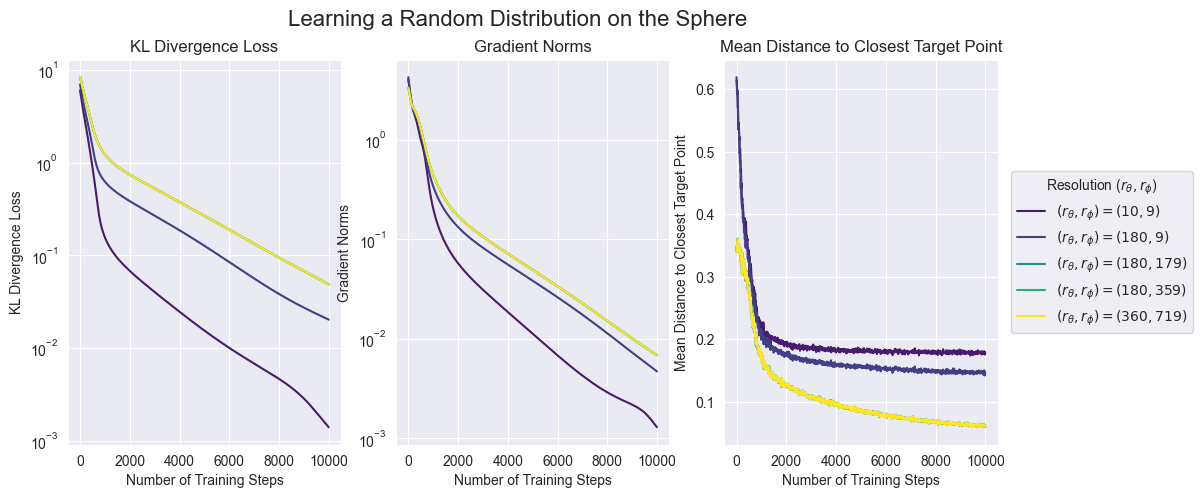

In [69]:
# Make a line plot of loss vs. number of training steps, for each choice of res_alpha and res_beta.
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
sns.set_style("darkgrid")
for res_alpha in res_alphas:
    for res_beta in res_betas:
        allowed_res_alphas_and_betas = [(9, 10), (9, 180), (179, 180), (359, 180), (719, 360)]
        if (res_alpha, res_beta) not in allowed_res_alphas_and_betas:
            continue
        color_value = get_color_value(res_alpha, res_beta)
        color = plt.cm.viridis(color_value)
        subset_df = results_df[(results_df["res_alpha"] == res_alpha) & (results_df["res_beta"] == res_beta)]
        steps = subset_df["steps"].iloc[0]
        loss = jnp.asarray(subset_df["loss"].iloc[0])
        grad_norms = jnp.asarray(subset_df["grad_norms"].iloc[0])
        mean_dist = jnp.asarray(subset_df["mean_dist"].iloc[0])

        axs[0].plot(steps, loss,
                    label=fr"$(r_\theta, r_\phi) = ({res_beta},{res_alpha})$",
                    color=color)

        axs[1].plot(steps, grad_norms,
                    label=fr"$(r_\theta, r_\phi) = ({res_beta},{res_alpha})$",
                    color=color)

        axs[2].plot(steps, mean_dist,
                label=fr"$(r_\theta, r_\phi) = ({res_beta},{res_alpha})$",
                color=color)
    
        # Also plot the std of the rmse, to get a sense of the variance.
        # std_dist = jnp.asarray(subset_df["std_dist"].iloc[0])
        # ax.fill_between(steps, mean_dist - std_dist, mean_dist + std_dist, alpha=0.2, color=color)


def extract_resolution_from_label(args):
    label, handle = args
    label = label.replace("$", "")
    label = label.replace("(", "")
    label = label.replace(")", "")
    label = label.split("=")[1].split(",")
    res_alpha = int(label[0])
    res_beta = int(label[1])
    return res_alpha * res_beta

fig.suptitle("Learning a Random Distribution on the Sphere", fontsize=16)
axs[0].set_yscale("log")
axs[0].set_title("KL Divergence Loss")
axs[0].set_ylabel("KL Divergence Loss")
axs[0].set_xlabel("Number of Training Steps")

axs[1].set_yscale("log")
axs[1].set_title("Gradient Norms")
axs[1].set_ylabel("Gradient Norms")
axs[1].set_xlabel("Number of Training Steps")

axs[2].set_title("Mean Distance to Closest Target Point")
axs[2].set_ylabel("Mean Distance to Closest Target Point")
axs[2].set_xlabel("Number of Training Steps")

# Sort legend by resolution
handles, labels = axs[0].get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=extract_resolution_from_label))
plt.legend(handles, labels, bbox_to_anchor=(1.05, 0.5), loc="center left", borderaxespad=0., title=r"Resolution ($r_\theta, r_\phi$)")
plt.savefig("pdfs/resolution_random_points.pdf", dpi=500, bbox_inches="tight")
plt.show()

<Figure size 640x480 with 0 Axes>

In [14]:
lmax = 5
position_channels = 1

coeffs = results_df[results_df["lmax"] == lmax]["coeffs"].values[position_channels - 1]
coeffs = e3nn.IrrepsArray(e3nn.s2_irreps(lmax, p_val=1, p_arg=-1), coeffs)
predicted_dist = models.log_coeffs_to_logits(coeffs, res_beta=90, res_alpha=179, num_radii=1)
predicted_dist = models.position_logits_to_position_distribution(predicted_dist)
samples_rng, rng = jax.random.split(rng)
samples = helpers.sample_from_dist(predicted_dist, samples_rng, num_samples=1000)

predicted_dist.grid_values = predicted_dist.grid_values[0]
fig = go.Figure([go.Surface(predicted_dist.plotly_surface(scale_radius_by_amplitude=False, radius=0.8, normalize_radius_by_max_amplitude=True)),
                 go.Scatter3d(x=samples[:, 0], y=samples[:, 1], z=samples[:, 2], mode='markers'),
                 go.Scatter3d(x=random_points[:, 0], y=random_points[:, 1], z=random_points[:, 2], mode='markers')])
fig.update_layout(scene = dict(
                    xaxis = dict(showticklabels=False, visible=False),
                    yaxis = dict(showticklabels=False, visible=False),
                    zaxis = dict(showticklabels=False, visible=False)))
fig.show()